In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
im_frame = cv2.imread("IMG_7188.jpg")
im_frame.shape

(4032, 3024, 3)

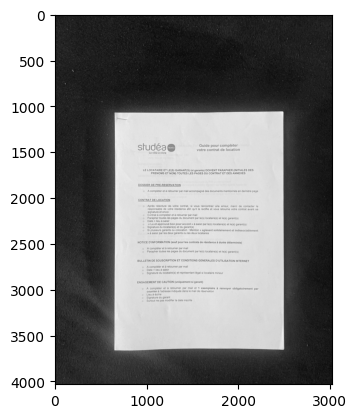

In [ ]:
# Convertir l'image en niveaux de gris
gray = cv2.cvtColor(im_frame, cv2.COLOR_BGR2GRAY)

# Appliquer un flou pour réduire le bruit
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

plt.imshow(blurred, cmap='gray')

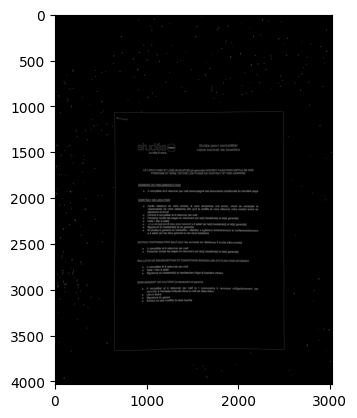

In [ ]:
# Utiliser la méthode de détection de contours par Canny
edged = cv2.Canny(blurred, 75, 200)

plt.imshow(edged, cmap='gray')

In [ ]:
# Trouver les contours dans l'image
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
len(contours)

4117

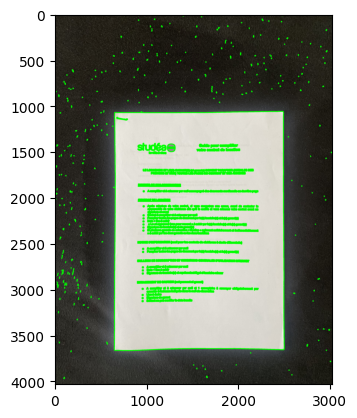

In [ ]:
def draw_contours(image, contours, color=(0, 255, 0), thickness=10):
  image_final = image.copy()
  for contour in contours:
      cv2.drawContours(image_final, [contour], -1, color, thickness)
  return cv2.cvtColor(image_final, cv2.COLOR_BGR2RGB)

plt.imshow(draw_contours(im_frame, contours))


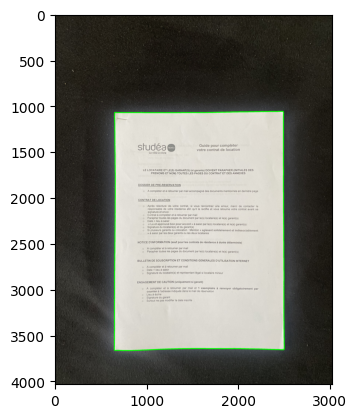

In [ ]:
# Initialiser une variable pour le plus grand quadrilatère
max_area = 0
best_contour = None

# Boucler sur les contours pour trouver le plus grand rectangle
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    area = w * h

    # Si l'aire du rectangle est plus grande que la précédente, mettre à jour
    if area > max_area:
        max_area = area
        best_contour = contour
plt.imshow(draw_contours(im_frame, [best_contour]))

In [ ]:
best_contour.shape

(451, 1, 2)

In [ ]:
epsilon = 0.02 * cv2.arcLength(best_contour, True)
approx = cv2.approxPolyDP(best_contour, epsilon, True)
approx.shape

(4, 1, 2)

In [ ]:
pts_src = approx.reshape(4, 2)
s = pts_src.sum(axis=1)
diff = np.diff(pts_src, axis=1)

top_left = pts_src[np.argmin(s)]
bottom_right = pts_src[np.argmax(s)]
top_right = pts_src[np.argmin(diff)]
bottom_left = pts_src[np.argmax(diff)]

pts_src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

# Définir les points de destination pour la transformation de perspective
width, height = im_frame.shape[1], im_frame.shape[0]
pts_dst = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

# Calculer la transformation de perspective
M = cv2.getPerspectiveTransform(pts_src, pts_dst)

# Appliquer la transformation de perspective
warped = cv2.warpPerspective(im_frame, M, (width, height))

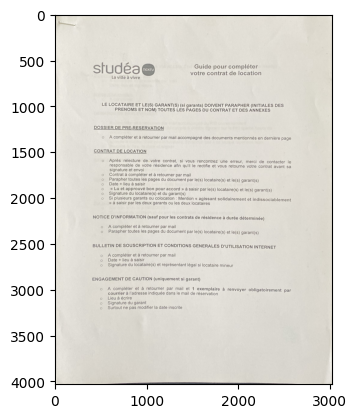

In [ ]:
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

Tracking on next frame

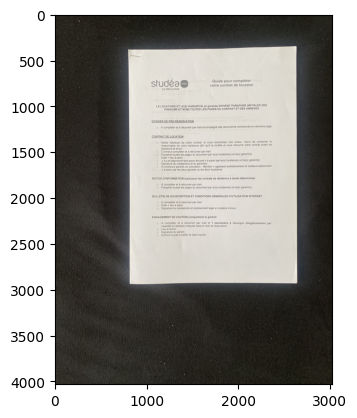

In [ ]:
next_frame = cv2.imread("IMG_7187.jpg")
plt.imshow(cv2.cvtColor(next_frame, cv2.COLOR_BGR2RGB))

Original bbox: x=645, y=1060, w=1849, h=2608
Adjusted bbox: x=645, y=1060, w=1849, h=2608


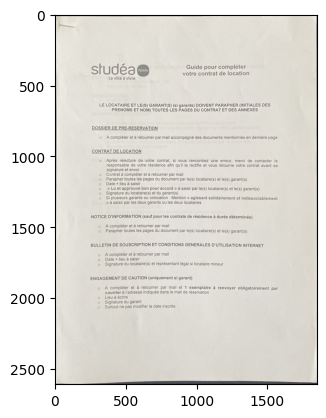

In [ ]:
x, y, w, h = cv2.boundingRect(best_contour)
print(f"Original bbox: x={x}, y={y}, w={w}, h={h}")

# Calculer les nouvelles dimensions en réduisant chaque dimension de 10%
scale_factor = 0.0
new_w = int(w * (1 - scale_factor))
new_h = int(h * (1 - scale_factor))

# Ajuster les coordonnées pour centrer la nouvelle bounding box
new_x = x + (w - new_w) // 2
new_y = y + (h - new_h) // 2

print(f"Adjusted bbox: x={new_x}, y={new_y}, w={new_w}, h={new_h}")

# Extraire la nouvelle ROI
roi = im_frame[int(new_y):int(new_y + new_h), int(new_x):int(new_x + new_w)]
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))

In [ ]:
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# Créer un masque pour filtrer les pixels non pertinents
mask = cv2.inRange(hsv_roi, np.array((0., 60., 32.)), np.array((180., 255., 255.)))

# Calculer l'histogramme de la ROI
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

# Critères de terminaison pour l'algorithme de MeanShift
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

# Convertir l'image courante en HSV
hsv = cv2.cvtColor(next_frame, cv2.COLOR_BGR2HSV)

# Backprojection de l'histogramme sur l'image courante
dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)

# Appliquer l'algorithme de MeanShift pour obtenir la nouvelle position
ret, track_window = cv2.meanShift(dst, (x, y, w, h), term_crit)

# Dessiner le rectangle de suivi sur l'image
x, y, w, h = track_window
next_frame_final = cv2.rectangle(next_frame.copy(), (x, y), (x + w, y + h), 255, 10)

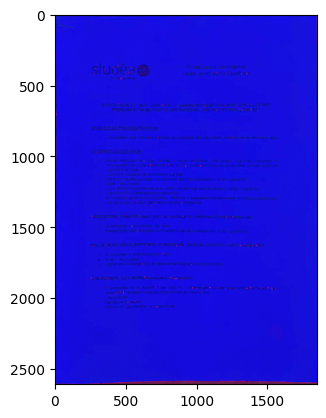

In [ ]:
next_frame_final = cv2.rectangle(next_frame.copy(), (x, y), (x + w, y + h), 255, 10)

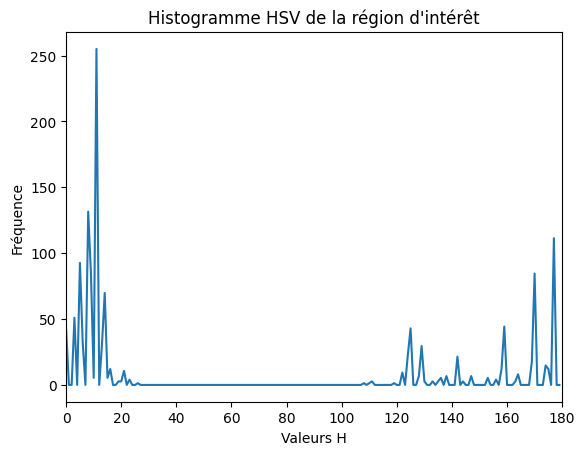

In [ ]:

# Tracer l'histogramme
plt.plot(roi_hist)
plt.xlim([0, 180])
plt.title('Histogramme HSV de la région d\'intérêt')
plt.xlabel('Valeurs H')
plt.ylabel('Fréquence')
plt.show()

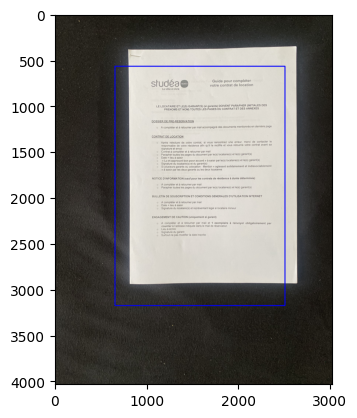

In [ ]:
plt.imshow(cv2.cvtColor(next_frame_final, cv2.COLOR_BGR2RGB))

Final solution

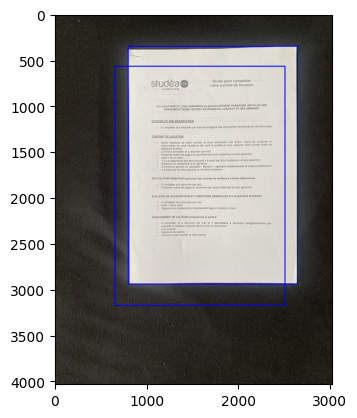

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def perspective_transform_with_largest_contour(image_path):
    # Charger l'image
    im_frame = cv2.imread(image_path)
    if im_frame is None:
        print("Erreur lors du chargement de l'image")
        return

    # Convertir en niveaux de gris
    gray = cv2.cvtColor(im_frame, cv2.COLOR_BGR2GRAY)

    # Appliquer un flou gaussien pour réduire le bruit
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Détecter les contours
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialiser une variable pour le plus grand quadrilatère
    max_area = 0
    best_contour = None
    rect = None

    # Boucler sur les contours pour trouver le plus grand rectangle
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:  # Vérifier si le contour a 4 coins
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h

            # Si l'aire du rectangle est plus grande que la précédente, mettre à jour
            if area > max_area:
                max_area = area
                best_contour = approx


    # Si un contour valide est trouvé
    if best_contour is not None:
        # Obtenir les points du quadrilatère
        pts_src = best_contour.reshape(4, 2)

        # Organiser les points du quadrilatère
        s = pts_src.sum(axis=1)
        diff = np.diff(pts_src, axis=1)

        top_left = pts_src[np.argmin(s)]
        bottom_right = pts_src[np.argmax(s)]
        top_right = pts_src[np.argmin(diff)]
        bottom_left = pts_src[np.argmax(diff)]

        pts_src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

        # Définir les points de destination pour la transformation de perspective
        width, height = im_frame.shape[1], im_frame.shape[0]
        pts_dst = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

        # Calculer la transformation de perspective
        M = cv2.getPerspectiveTransform(pts_src, pts_dst)

        # Appliquer la transformation de perspective
        warped = cv2.warpPerspective(im_frame, M, (width, height))

        # Afficher l'image transformée
        plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        plt.title('Image Agrandie')
        plt.show()

        return warped
    else:
        print("Aucun quadrilatère valide trouvé.")
        return None

# Exemple d'utilisation de la fonction


Implementation de canny edges detections

In [ ]:
def Canny_detector(img, weak_th = None, strong_th = None):

    # conversion of image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Noise reduction step
    img = cv2.GaussianBlur(img, (5, 5), 1.4)

    # Calculating the gradients
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)

    # Conversion of Cartesian coordinates to polar
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True)

    # setting the minimum and maximum thresholds
    # for double thresholding
    mag_max = np.max(mag)
    if not weak_th:weak_th = mag_max * 0.1
    if not strong_th:strong_th = mag_max * 0.5

    # getting the dimensions of the input image
    height, width = img.shape

    # Looping through every pixel of the grayscale
    # image
    for i_x in range(width):
        for i_y in range(height):

            grad_ang = ang[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)

            # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

            # top right (diagonal-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1

            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1

            # top left (diagonal-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1

            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

            # Non-maximum suppression step
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x]= 0
                    continue

            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x]= 0

    weak_ids = np.zeros_like(img)
    strong_ids = np.zeros_like(img)
    ids = np.zeros_like(img)

    # double thresholding step
    for i_x in range(width):
        for i_y in range(height):

            grad_mag = mag[i_y, i_x]

            if grad_mag<weak_th:
                mag[i_y, i_x]= 0
            elif strong_th>grad_mag>= weak_th:
                ids[i_y, i_x]= 1
            else:
                ids[i_y, i_x]= 2


    # finally returning the magnitude of
    # gradients of edges
    return mag

In [ ]:
edged = Canny_detector(im_frame, 75, 200)

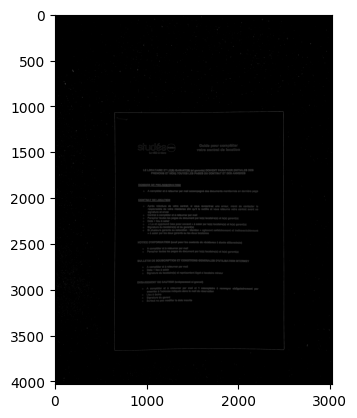

In [ ]:
plt.imshow(edged, cmap='gray')

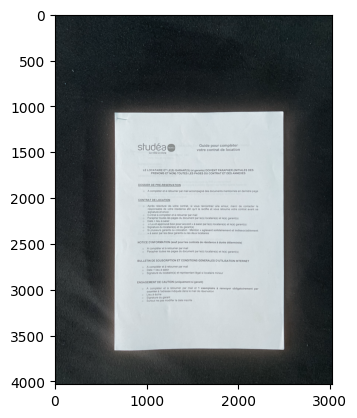

In [ ]:
ratio = round(im_frame.shape[1] / im_frame.shape[0], 3)
width = int(im_frame.shape[1] * ratio)
dim = (width, im_frame.shape[0])

#frame_resized = cv2.resize(im_frame, dim, interpolation=cv2.INTER_LINEAR)
frame_resized = im_frame.copy()
plt.imshow(frame_resized)

In [ ]:

lab_processed.shape

(4032, 3024, 3)

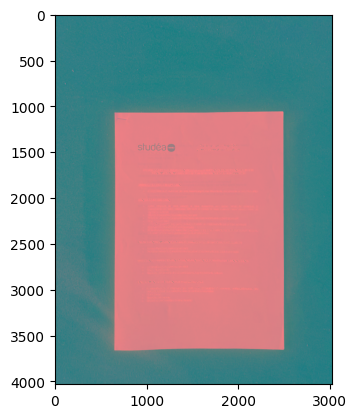

In [ ]:
#im_after_preposs = cv2.cvtColor(lab_processed, cv2.COLOR_LAB2RGB)
plt.imshow(lab_processed)

Step2: Segmentation into Regions

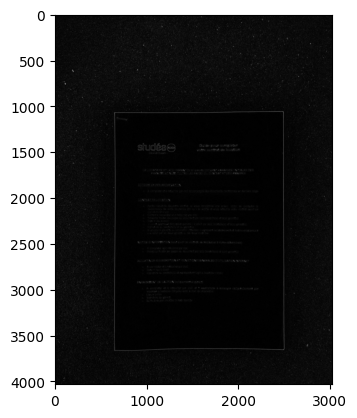

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
L, a, b = cv2.split(lab_processed)
def compute_gradient(channel):
    dilated = cv2.dilate(channel, kernel)
    eroded = cv2.erode(channel, kernel)
    return dilated - eroded
# delta = dilation - erosion
delta_L = compute_gradient(L)
delta_a = compute_gradient(a)
delta_b = compute_gradient(b)
sum_delta = delta_L + delta_a + delta_b
gradient_closed = cv2.morphologyEx(sum_delta, cv2.MORPH_CLOSE, kernel)
plt.imshow(gradient_closed, cmap='gray')

In [ ]:
gradient_closed.shape

(4032, 3024)

(4032, 3024)


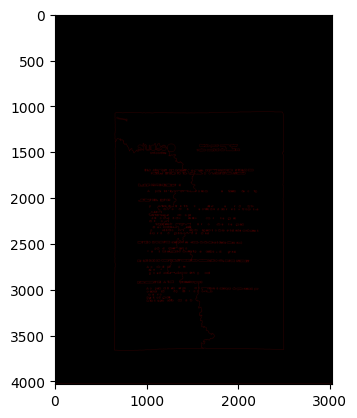

In [ ]:

ret, thresh = cv2.threshold(gradient_closed,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(frame_resized,markers)
image_blacked = np.zeros_like(frame_resized)
image_blacked[markers == -1] = [255,0,0]
print(markers.shape)

#plt.imsave("image_blacked.jpg", image_blacked)
plt.imshow(image_blacked)


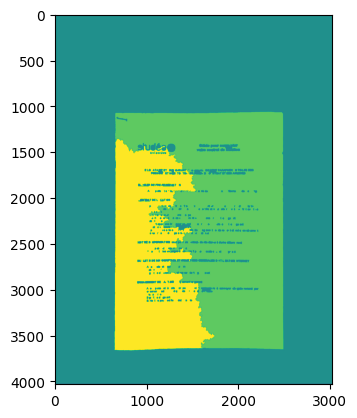

In [ ]:
plt.imshow(markers)

In [ ]:
image_blacked_gray = cv2.cvtColor(image_blacked, cv2.COLOR_BGR2GRAY)

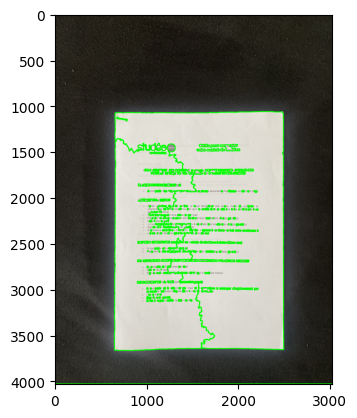

In [ ]:
contours, _ = cv2.findContours(image_blacked_gray.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
def draw_contours(image, contours, color=(0, 255, 0), thickness=10):
  image_final = image.copy()
  for contour in contours:
      cv2.drawContours(image_final, [contour], -1, color, thickness)
  return cv2.cvtColor(image_final, cv2.COLOR_BGR2RGB)

plt.imshow(draw_contours(im_frame, contours))

In [ ]:
markers.shape

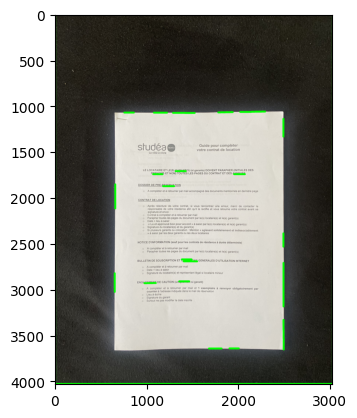

In [ ]:
cop_im = im_frame.copy()

lines = cv2.HoughLinesP(
            image_blacked_gray, # Input edge image
            1, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            threshold=100, # Min number of votes for valid line
            minLineLength=100, # Min allowed length of line
            maxLineGap=10 # Max allowed gap between line for joining them
            )
lines_list =[]
for points in lines:
      # Extracted points nested in the list
    x1,y1,x2,y2=points[0]
    # Draw the lines joing the points
    # On the original image
    cv2.line(cop_im,(x1,y1),(x2,y2),(0,255,0),20)
    # Maintain a simples lookup list for points
    lines_list.append([(x1,y1),(x2,y2)])
plt.imshow(cv2.cvtColor(cop_im, cv2.COLOR_BGR2RGB))

selected_vertical_segments: [[(3023, 0), (3023, 4031)], [(0, 0), (0, 4031)], [(2484, 0), (2484, 4031)], [(2485, 0), (2485, 4031)], [(655, 0), (655, 4031)], [(2485, 0), (2485, 4031)], [(649, 0), (649, 4031)], [(2484, 0), (2484, 4031)], [(2487, 0), (2487, 4031)], [(2486, 0), (2486, 4031)]]
selected_horizontal_segments: [[(0, 4031), (3023, 4031)], [(0, 0), (3023, 0)], [(0, 3645), (3023, 3645)], [(0, 1077), (3023, 1077)], [(0, 1075), (3023, 1075)], [(0, 1074), (3023, 1074)], [(0, 2695), (3023, 2695)], [(0, 3644), (3023, 3644)], [(0, 1745), (3023, 1745)], [(0, 1067), (3023, 1067)]]


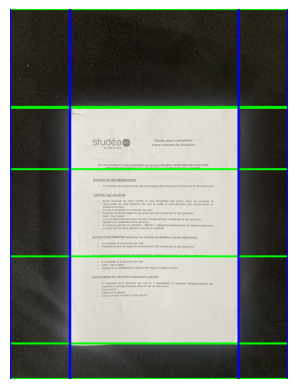

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_intersection_points(x1, y1, x2, y2, width, height):
    points = []
    if x2 != x1:
        y = int(y1 + (0 - x1) * (y2 - y1) / (x2 - x1))
        if 0 <= y < height:
            points.append((0, y))
        y = int(y1 + (width - 1 - x1) * (y2 - y1) / (x2 - x1))
        if 0 <= y < height:
            points.append((width - 1, y))
    if y2 != y1:
        x = int(x1 + (0 - y1) * (x2 - x1) / (y2 - y1))
        if 0 <= x < width:
            points.append((x, 0))
        x = int(x1 + (height - 1 - y1) * (x2 - x1) / (y2 - y1))
        if 0 <= x < width:
            points.append((x, height - 1))
    return points

def draw_segments(image, segments, color=(0, 0, 255), thickness=20):
    for segment in segments:
        if len(segment) >= 2:
            cv2.line(image, segment[0], segment[1], color, thickness)
    return image

def classify_segments(segments):
    horizontal_segments = []
    vertical_segments = []

    for segment in segments:
        (x1, y1), (x2, y2) = segment
        if abs(y2 - y1) < abs(x2 - x1):  # Horizontal segment
            horizontal_segments.append(segment)
        else:  # Vertical segment
            vertical_segments.append(segment)

    return horizontal_segments, vertical_segments

def calculate_segment_attributes(segment, watershed_image):
    (x1, y1), (x2, y2) = segment
    length = np.linalg.norm(np.array((x1, y1)) - np.array((x2, y2)))
    bre = bresenham(x1, y1, x2, y2)
    distance_to_watershed = np.mean([watershed_image[y, x] for x, y in bre])
    return length, distance_to_watershed

def bresenham(x1, y1, x2, y2):
    points = []
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        points.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    return points

segments = []
for line in lines_list:

    (x1, y1), (x2, y2) = line
    points = get_intersection_points(x1, y1, x2, y2, im_frame.shape[1], im_frame.shape[0])
    if len(points) == 2:
        segments.append(points)

# Obtenir les dimensions de l'image
height, width = im_frame.shape[:2]


# Classifier les segments en horizontaux et verticaux
horizontal_segments, vertical_segments = classify_segments(segments)

# Calculer les attributs des segments
vertical_segment_attributes = []
horizontal_segment_attributes = []
for segment in vertical_segments:
    length, distance_to_watershed = calculate_segment_attributes(segment, image_blacked_gray)
    vertical_segment_attributes.append((segment, length, distance_to_watershed))
for segment in horizontal_segments:
    length, distance_to_watershed = calculate_segment_attributes(segment, image_blacked_gray)
    horizontal_segment_attributes.append((segment, length, distance_to_watershed))

# Sélectionner les segments basés sur l'énergie U (simplification)
selected_vertical_segments = sorted(vertical_segment_attributes, key=lambda x: x[1])[:10]

selected_horizontal_segments = sorted(horizontal_segment_attributes, key=lambda x: x[1])[:10]



def filter_segment_Image_shape(segments, width, height):
  filtered_segments = []
  for segment, length, energy in segments:
    p1, p2 = segment

    points= get_intersection_points(p1[0], p1[1], p2[0], p2[1], width, height)
    if len(points) == 2:
      filtered_segments.append(segment)
  return filtered_segments


selected_vertical_segments = filter_segment_Image_shape(selected_vertical_segments, width, height)
selected_horizontal_segments = filter_segment_Image_shape(selected_horizontal_segments, width, height)

print("selected_vertical_segments:", selected_vertical_segments)
print("selected_horizontal_segments:", selected_horizontal_segments)

# Tracer les segments sélectionnés
cop_im = im_frame.copy()
cop_im = draw_segments(cop_im, selected_horizontal_segments, color=(0, 255, 0))
cop_im = draw_segments(cop_im, selected_vertical_segments, color=(255, 0, 0))

plt.imshow(cv2.cvtColor(cop_im, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


selected_vertical_segments: [[(0, 0), (0, 4031)], [(3023, 0), (3023, 4031)], [(2484, 0), (2484, 4031)], [(655, 0), (655, 4031)], [(649, 0), (649, 4031)]]
selected_horizontal_segments: [[(0, 4030), (999, 4031)], [(0, 0), (3023, 0)], [(0, 3644), (3023, 3646)], [(0, 1076), (3023, 1078)], [(0, 1073), (3023, 1075)], [(0, 1102), (3023, 1049)]]


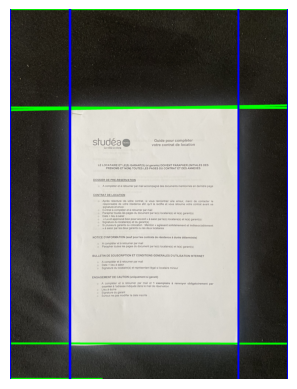

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_intersection_points(x1, y1, x2, y2, width, height):
    points = []
    if x2 != x1:
        y = int(y1 + (0 - x1) * (y2 - y1) / (x2 - x1))
        if 0 <= y < height:
            points.append((0, y))
        y = int(y1 + (width - 1 - x1) * (y2 - y1) / (x2 - x1))
        if 0 <= y < height:
            points.append((width - 1, y))
    if y2 != y1:
        x = int(x1 + (0 - y1) * (x2 - x1) / (y2 - y1))
        if 0 <= x < width:
            points.append((x, 0))
        x = int(x1 + (height - 1 - y1) * (x2 - x1) / (y2 - y1))
        if 0 <= x < width:
            points.append((x, height - 1))
    return points

def draw_segments(image, segments, color=(0, 0, 255), thickness=20):
    for segment in segments:
        if len(segment) >= 2:
            cv2.line(image, segment[0], segment[1], color, thickness)
    return image

def classify_segments(segments):
    horizontal_segments = []
    vertical_segments = []

    for segment in segments:
        (x1, y1), (x2, y2) = segment
        if abs(y2 - y1) < abs(x2 - x1):  # Horizontal segment
            horizontal_segments.append(segment)
        else:  # Vertical segment
            vertical_segments.append(segment)

    return horizontal_segments, vertical_segments

def calculate_segment_attributes(segment, watershed_image):
    (x1, y1), (x2, y2) = segment
    length = np.linalg.norm(np.array((x1, y1)) - np.array((x2, y2)))
    bre = bresenham(x1, y1, x2, y2)
    distance_to_watershed = np.mean([watershed_image[y, x] for x, y in bre])
    return length, distance_to_watershed

def bresenham(x1, y1, x2, y2):
    points = []
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        points.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    return points

# Appliquer la transformée de Hough pour détecter les lignes
lines = cv2.HoughLines(image_blacked_gray, 1, np.pi/180, 250)
segments = []

# Obtenir les dimensions de l'image
height, width = im_frame.shape[:2]

# Découper les lignes détectées en segments (chunks)
for r_theta in lines:
    arr = np.array(r_theta[0], dtype=np.float64)
    r, theta = arr
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * r
    y0 = b * r
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    points = get_intersection_points(x1, y1, x2, y2, width, height)

    if len(points) == 2:
        segments.append(points)

# Classifier les segments en horizontaux et verticaux
horizontal_segments, vertical_segments = classify_segments(segments)

# Calculer les attributs des segments
vertical_segment_attributes = []
horizontal_segment_attributes = []
for segment in vertical_segments:
    length, distance_to_watershed = calculate_segment_attributes(segment, image_blacked_gray)
    vertical_segment_attributes.append((segment, length, distance_to_watershed))
for segment in horizontal_segments:
    length, distance_to_watershed = calculate_segment_attributes(segment, image_blacked_gray)
    horizontal_segment_attributes.append((segment, length, distance_to_watershed))

# Sélectionner les segments basés sur l'énergie U (simplification)
selected_vertical_segments = sorted(vertical_segment_attributes, key=lambda x: x[1])[:10]

selected_horizontal_segments = sorted(horizontal_segment_attributes, key=lambda x: x[1])[:10]



def filter_segment_Image_shape(segments, width, height):
  filtered_segments = []
  for segment, length, energy in segments:
    p1, p2 = segment

    points= get_intersection_points(p1[0], p1[1], p2[0], p2[1], width, height)
    if len(points) == 2:
      filtered_segments.append(segment)
  return filtered_segments


selected_vertical_segments = filter_segment_Image_shape(selected_vertical_segments, width, height)
selected_horizontal_segments = filter_segment_Image_shape(selected_horizontal_segments, width, height)

print("selected_vertical_segments:", selected_vertical_segments)
print("selected_horizontal_segments:", selected_horizontal_segments)

def classify_segments(segments_hori, segments_vert, width, height):
    top_segments = []
    bottom_segments = []
    left_segments = []
    right_segments = []
    margin = 50
    for segment in segments_hori:

        (x1, y1), (x2, y2) = segment
        # Éliminer les segments proches des bords de l'image
        if (x1 < margin and x2 < margin) or (x1 > width - margin and x2 > width - margin):
            continue
        if (y1 < margin and y2 < margin) or (y1 > height - margin and y2 > height - margin):
            continue
        # Segment horizontal
        if y1 < height // 2:
            top_segments.append(segment)
        else:
            bottom_segments.append(segment)

    for segment in segments_vert:
        (x1, y1), (x2, y2) = segment
        # Éliminer les segments proches des bords de l'image
        if (x1 < margin and x2 < margin) or (x1 > width - margin and x2 > width - margin):
            continue
        if (y1 < margin and y2 < margin) or (y1 > height - margin and y2 > height - margin):
            continue
        # Segment vertical
        if x1 < width // 2:
            left_segments.append(segment)
        else:
          right_segments.append(segment)


    return top_segments, bottom_segments, left_segments, right_segments



# Tracer les segments sélectionnés
cop_im = im_frame.copy()
cop_im = draw_segments(cop_im, selected_horizontal_segments, color=(0, 255, 0))
cop_im = draw_segments(cop_im, selected_vertical_segments, color=(255, 0, 0))

plt.imshow(cv2.cvtColor(cop_im, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


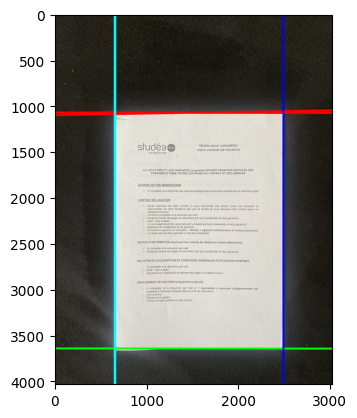

In [ ]:
top_segments, bottom_segments, left_segments, right_segments = classify_segments(selected_horizontal_segments, selected_vertical_segments, width, height)
# Tracer les segments sélectionnés et classifiés
cop_im = im_frame.copy()
cop_im = draw_segments(cop_im, top_segments)
cop_im = draw_segments(cop_im, bottom_segments, color=(0, 255, 0))
cop_im = draw_segments(cop_im, left_segments, color=(255, 255, 0))
cop_im = draw_segments(cop_im, right_segments, color=(255, 0, 0))

plt.imshow(cv2.cvtColor(cop_im, cv2.COLOR_BGR2RGB))

Top left: (655.0, 1076.4333443599073)
Top right: (2484.0, 1077.643400595435)
Bottom left: (655.0, 3644.4333443599076)
Bottom right: (2484.0, 3645.643400595435)


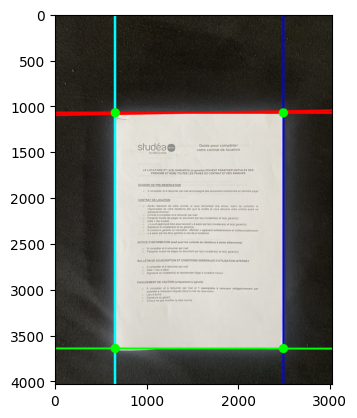

In [ ]:
# Fonction pour trouver l'intersection de deux lignes
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       return None

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y
top_segment = top_segments[0] if top_segments else None
bottom_segment = bottom_segments[0] if bottom_segments else None
left_segment = left_segments[0] if left_segments else None
right_segment = right_segments[0] if right_segments else None

# Trouver les intersections des segments pour obtenir les coins du rectangle
top_left = line_intersection(top_segment, left_segment) if top_segment and left_segment else None
top_right = line_intersection(top_segment, right_segment) if top_segment and right_segment else None
bottom_left = line_intersection(bottom_segment, left_segment) if bottom_segment and left_segment else None
bottom_right = line_intersection(bottom_segment, right_segment) if bottom_segment and right_segment else None

# Afficher les points des coins du rectangle
print("Top left:", top_left)
print("Top right:", top_right)
print("Bottom left:", bottom_left)
print("Bottom right:", bottom_right)
if top_left:
    cv2.circle(cop_im, tuple(map(int, top_left)), 50, (0, 255, 0), -1)
if top_right:
    cv2.circle(cop_im, tuple(map(int, top_right)), 50, (0, 255, 0), -1)
if bottom_left:
    cv2.circle(cop_im, tuple(map(int, bottom_left)), 50, (0, 255, 0), -1)
if bottom_right:
    cv2.circle(cop_im, tuple(map(int, bottom_right)), 50, (0, 255, 0), -1)
plt.imshow(cv2.cvtColor(cop_im, cv2.COLOR_BGR2RGB))

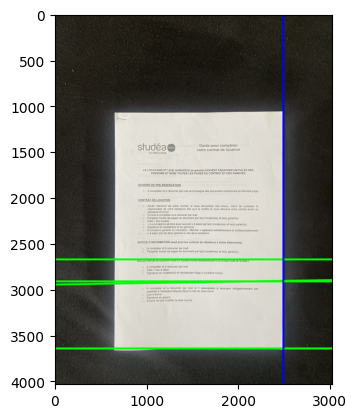

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour obtenir les points d'intersection avec les bords de l'image
def get_intersection_points(x1, y1, x2, y2, width, height):
    points = []
    if x2 != x1:
        y = int(y1 + (0 - x1) * (y2 - y1) / (x2 - x1))
        if 0 <= y < height:
            points.append((0, y))
        y = int(y1 + (width - 1 - x1) * (y2 - y1) / (x2 - x1))
        if 0 <= y < height:
            points.append((width - 1, y))
    if y2 != y1:
        x = int(x1 + (0 - y1) * (x2 - x1) / (y2 - y1))
        if 0 <= x < width:
            points.append((x, 0))
        x = int(x1 + (height - 1 - y1) * (x2 - x1) / (y2 - y1))
        if 0 <= x < width:
            points.append((x, height - 1))
    return points

# Fonction pour tracer les segments sur une image
def draw_segments(image, segments, color=(0, 0, 255), thickness=20):
    for segment in segments:
        if len(segment) >= 2:
            cv2.line(image, segment[0], segment[1], color, thickness)
    return image

# Fonction pour classer les segments en catégories (haut, bas, gauche, droite)
def classify_segments(segments, width, height):
    top_segments = []
    bottom_segments = []
    left_segments = []
    right_segments = []
    margin = 50
    for segment, length, energy, delta_s in segments:
        (x1, y1), (x2, y2) = segment

        # Éliminer les segments proches des bords de l'image
        if (x1 < margin and x2 < margin) or (x1 > width - margin and x2 > width - margin):
            continue
        if (y1 < margin and y2 < margin) or (y1 > height - margin and y2 > height - margin):
            continue
        if abs(y2 - y1) < abs(x2 - x1) :  # Segment horizontal
            if  delta_s > 0 :
                top_segments.append(segment)
            else:
                bottom_segments.append(segment)
        else:  # Segment vertical
            if  delta_s > 0 :
                left_segments.append(segment)
            else:
                right_segments.append(segment)
    return top_segments, bottom_segments, left_segments, right_segments

# Fonction pour calculer la variation de saturation
def calculate_saturation_variation(segment, markers):
    (x1, y1), (x2, y2) = segment
    if abs(y2 - y1) < abs(x2 - x1):  # Segment horizontal
        region1_labels = markers[max(0, y1 - 2):min(markers.shape[0], y1 + 2), x1:x2]
        region2_labels = markers[max(0, y1 + 2):min(markers.shape[0], y1 + 6), x1:x2]
    else:  # Segment vertical
        region1_labels = markers[y1:y2, max(0, x1 - 2):min(markers.shape[1], x1 + 2)]
        region2_labels = markers[y1:y2, max(0, x1 + 2):min(markers.shape[1], x1 + 6)]
    region1_saturation = np.mean(region1_labels)
    region2_saturation = np.mean(region2_labels)
    delta_s = region2_saturation - region1_saturation
    return delta_s

segments = lines_list

# Obtenir les dimensions de l'image
height, width = im_frame.shape[:2]



# Calculer les attributs des segments
segments_attributes = []
for segment in segments:
    (x1, y1), (x2, y2) = segment

    segment = get_intersection_points(x1, y1, x2, y2, width, height)
    p1, p2 = segment
    length, distance_to_watershed = calculate_segment_attributes(segment, image_blacked_gray)
    energy = distance_to_watershed / np.sqrt(length + 1)
    # Calculer la variation de saturation
    delta_s = calculate_saturation_variation(segment, markers)
    segments_attributes.append((segment, length, energy, delta_s))


# Sélectionner les segments basés sur l'énergie U
selected_segments = sorted(segments_attributes, key=lambda x: x[3])
filtered_segments = []
last_value = None

for segment in selected_segments:
    current_value = segment[3]
    if current_value != last_value:
        filtered_segments.append(segment)
        last_value = current_value

# Sélectionner les 10 premiers segments triés et filtrés
selected_segments = filtered_segments[:10]


# Classifier les segments en catégories (haut, bas, gauche, droite)
top_segments, bottom_segments, left_segments, right_segments = classify_segments(selected_segments, width, height)

# Affichage des segments
cop_im = im_frame.copy()
cop_im = draw_segments(cop_im, top_segments)
cop_im = draw_segments(cop_im, bottom_segments, color=(0, 255, 0))
cop_im = draw_segments(cop_im, left_segments, color=(255, 255, 0))
cop_im = draw_segments(cop_im, right_segments, color=(255, 0, 0))
plt.imshow(cv2.cvtColor(cop_im, cv2.COLOR_BGR2RGB))




In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour obtenir les points d'intersection avec les bords de l'image
def get_intersection_points(x1, y1, x2, y2, width, height):
    points = []

    # Intersection avec la bordure gauche (x = 0)
    if x2 != x1:
        y = int(y1 + (0 - x1) * (y2 - y1) / (x2 - x1))
        if 0 <= y < height:
            points.append((0, y))

    # Intersection avec la bordure droite (x = width - 1)
    if x2 != x1:
        y = int(y1 + (width - 1 - x1) * (y2 - y1) / (x2 - x1))
        if 0 <= y < height:
            points.append((width - 1, y))

    # Intersection avec la bordure supérieure (y = 0)
    if y2 != y1:
        x = int(x1 + (0 - y1) * (x2 - x1) / (y2 - y1))
        if 0 <= x < width:
            points.append((x, 0))

    # Intersection avec la bordure inférieure (y = height - 1)
    if y2 != y1:
        x = int(x1 + (height - 1 - y1) * (x2 - x1) / (y2 - y1))
        if 0 <= x < width:
            points.append((x, height - 1))

    return points

# Fonction pour tracer les segments sur une image
def draw_segments(image, segments, color=(0, 0, 255)):
    for segment in segments:
        if len(segment) >= 2:
            cv2.line(image, segment[0], segment[1], color, 20)
    return image

# Fonction pour classer les segments en catégories (haut, bas, gauche, droite)
def classify_segments(segments, width, height):
    top_segments = []
    bottom_segments = []
    left_segments = []
    right_segments = []

    for segment in segments:
        (x1, y1), (x2, y2) = segment
        if abs(y2 - y1) < abs(x2 - x1):  # Segment horizontal
            if y1 < height // 2:
                top_segments.append(segment)
            else:
                bottom_segments.append(segment)
        else:  # Segment vertical
            if x1 < width // 2:
                left_segments.append(segment)
            else:
                right_segments.append(segment)

    return top_segments, bottom_segments, left_segments, right_segments

# Étape 1: Appliquer la transformée de Hough pour détecter les lignes
lines = cv2.HoughLines(image_blacked_gray, 1, np.pi/180, 200)
segments = []

# Obtenir les dimensions de l'image
height, width = im_frame.shape[:2]

# Étape 2: Découper les lignes en segments (chunks)
for r_theta in lines:
    arr = np.array(r_theta[0], dtype=np.float64)
    r, theta = arr
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * r
    y0 = b * r
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    points = get_intersection_points(x1, y1, x2, y2, width, height)
    if len(points) == 2:
        segments.append(points)

# Étape 3: Calculer les attributs des segments
segments_attributes = []
for segment in segments:
    p1, p2 = segment
    length = np.linalg.norm(np.array(p1) - np.array(p2))
    # Simplifions la distance à une constante pour cet exemple
    distance = 1
    energy = distance / np.sqrt(length + 1)
    segments_attributes.append((segment, length, energy))

# Étape 4: Sélectionner les segments basés sur l'énergie U
selected_segments = sorted(segments_attributes, key=lambda x: x[2])[:10]

# Étendre les segments sélectionnés pour traverser toute l'image
extended_segments = []
for segment, length, energy in selected_segments:
    p1, p2 = segment
    extended_segment = get_intersection_points(p1[0], p1[1], p2[0], p2[1], width, height)
    if len(extended_segment) == 2:
        extended_segments.append(extended_segment)

# Étape 5: Classifier les segments en catégories (haut, bas, gauche, droite)
top_segments, bottom_segments, left_segments, right_segments = classify_segments(extended_segments, width, height)


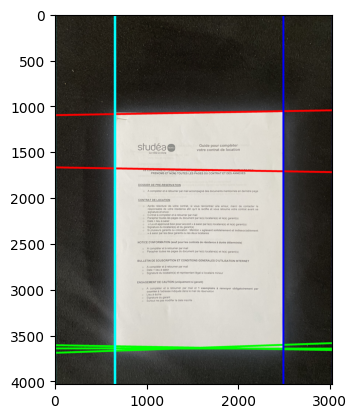

In [ ]:
# Tracer les segments sélectionnés et classifiés
cop_im = im_frame.copy()
cop_im = draw_segments(cop_im, top_segments)
cop_im = draw_segments(cop_im, bottom_segments, color=(0, 255, 0))
cop_im = draw_segments(cop_im, left_segments, color=(255, 255, 0))
cop_im = draw_segments(cop_im, right_segments, color=(255, 0, 0))

plt.imshow(cv2.cvtColor(cop_im, cv2.COLOR_BGR2RGB))

Top left: (0.0, 1102.0)
Top right: (3023.0, 1049.0)
Bottom left: (0.0, 3692.0)
Bottom right: (3023.0, 3586.0)


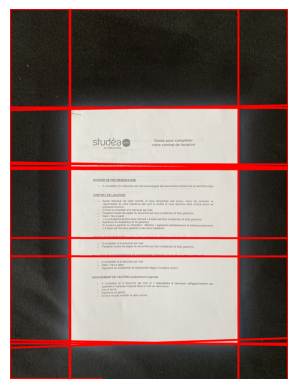

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour obtenir les points d'intersection avec les bords de l'image
def get_intersection_points(x1, y1, x2, y2, width, height):
    points = []

    # Intersection avec la bordure gauche (x = 0)
    if x2 != x1:
        y = int(y1 + (0 - x1) * (y2 - y1) / (x2 - x1))
        if 0 <= y < height:
            points.append((0, y))

    # Intersection avec la bordure droite (x = width - 1)
    if x2 != x1:
        y = int(y1 + (width - 1 - x1) * (y2 - y1) / (x2 - x1))
        if 0 <= y < height:
            points.append((width - 1, y))

    # Intersection avec la bordure supérieure (y = 0)
    if y2 != y1:
        x = int(x1 + (0 - y1) * (x2 - x1) / (y2 - y1))
        if 0 <= x < width:
            points.append((x, 0))

    # Intersection avec la bordure inférieure (y = height - 1)
    if y2 != y1:
        x = int(x1 + (height - 1 - y1) * (x2 - x1) / (y2 - y1))
        if 0 <= x < width:
            points.append((x, height - 1))

    return points

# Fonction pour tracer les segments sur une image
def draw_segments(image, segments, color=(0, 0, 255), thickness=20):
    for segment in segments:
        if len(segment) >= 2:
            cv2.line(image, segment[0], segment[1], color, thickness)
    return image

# Fonction pour classer les segments en catégories (haut, bas, gauche, droite)
def classify_segments(segments, width, height):
    top_segments = []
    bottom_segments = []
    left_segments = []
    right_segments = []

    margin = 50  # Marge pour éviter les bords de l'image

    for segment in segments:
        (x1, y1), (x2, y2) = segment

        # Éliminer les segments proches des bords de l'image
        """if (x1 < margin and x2 < margin) or (x1 > width - margin and x2 > width - margin):
            continue
        if (y1 < margin and y2 < margin) or (y1 > height - margin and y2 > height - margin):
            continue
"""
        if abs(y2 - y1) < abs(x2 - x1):  # Segment horizontal
            if y1 < height // 2:
                top_segments.append(segment)
            else:
                bottom_segments.append(segment)
        else:  # Segment vertical
            if x1 < width // 2:
                left_segments.append(segment)
            else:
                right_segments.append(segment)

    return top_segments, bottom_segments, left_segments, right_segments

# Fonction pour trouver l'intersection de deux lignes
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       return None

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

# Étape 1: Appliquer la transformée de Hough pour détecter les lignes
lines = cv2.HoughLines(image_blacked_gray, 1, np.pi/180, 200)
segments = []

# Obtenir les dimensions de l'image
height, width = im_frame.shape[:2]

# Étape 2: Découper les lignes en segments (chunks)
for r_theta in lines:
    arr = np.array(r_theta[0], dtype=np.float64)
    r, theta = arr
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * r
    y0 = b * r
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    points = get_intersection_points(x1, y1, x2, y2, width, height)
    if len(points) == 2:
        segments.append(points)

# Étape 3: Calculer les attributs des segments
segments_attributes = []
for segment in segments:
    p1, p2 = segment
    length = np.linalg.norm(np.array(p1) - np.array(p2))
    # Simplifions la distance à une constante pour cet exemple
    distance = 1
    energy = distance / np.sqrt(length + 1)
    segments_attributes.append((segment, length, energy))

# Étape 4: Sélectionner les segments basés sur l'énergie U
selected_segments = sorted(segments_attributes, key=lambda x: x[2])[:20]

# Étendre les segments sélectionnés pour traverser toute l'image
extended_segments = []
for segment, length, energy in selected_segments:
    p1, p2 = segment
    extended_segment = get_intersection_points(p1[0], p1[1], p2[0], p2[1], width, height)
    if len(extended_segment) == 2:
        extended_segments.append(extended_segment)

# Étape 5: Classifier les segments en catégories (haut, bas, gauche, droite)
top_segments, bottom_segments, left_segments, right_segments = classify_segments(extended_segments, width, height)

# Sélectionner un segment de chaque catégorie pour déterminer les limites du document
top_segment = top_segments[0] if top_segments else None
bottom_segment = bottom_segments[0] if bottom_segments else None
left_segment = left_segments[0] if left_segments else None
right_segment = right_segments[0] if right_segments else None

# Trouver les intersections des segments pour obtenir les coins du rectangle
top_left = line_intersection(top_segment, left_segment) if top_segment and left_segment else None
top_right = line_intersection(top_segment, right_segment) if top_segment and right_segment else None
bottom_left = line_intersection(bottom_segment, left_segment) if bottom_segment and left_segment else None
bottom_right = line_intersection(bottom_segment, right_segment) if bottom_segment and right_segment else None

# Afficher les points des coins du rectangle
print("Top left:", top_left)
print("Top right:", top_right)
print("Bottom left:", bottom_left)
print("Bottom right:", bottom_right)

# Tracer les segments sélectionnés et les points des coins du rectangle
cop_im = im_frame.copy()
cop_im = draw_segments(cop_im, top_segments)
cop_im = draw_segments(cop_im, bottom_segments)
cop_im = draw_segments(cop_im, left_segments)
cop_im = draw_segments(cop_im, right_segments)

# Tracer les points des coins du rectangle
"""if top_left:
    cv2.circle(cop_im, tuple(map(int, top_left)), 50, (0, 255, 0), -1)
if top_right:
    cv2.circle(cop_im, tuple(map(int, top_right)), 50, (0, 255, 0), -1)
if bottom_left:
    cv2.circle(cop_im, tuple(map(int, bottom_left)), 50, (0, 255, 0), -1)
if bottom_right:
    cv2.circle(cop_im, tuple(map(int, bottom_right)), 50, (0, 255, 0), -1)"""

plt.imshow(cv2.cvtColor(cop_im, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:

pts_src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

# Définir les points de destination pour la transformation de perspective
width, height = im_frame.shape[1], im_frame.shape[0]
pts_dst = np.float32([[0, 0], [width, 0], [width, height], [0, height]])


array([[ 1.62556164e+00, -3.35366069e-17, -1.06474287e+03],
       [ 2.72934853e-02,  1.55675676e+00, -1.71554594e+03],
       [-6.76921760e-06,  4.91258890e-20,  1.00000000e+00]])